# Notebook for the Indirect social influence helps shaping the diffusion of innovations

This notebook reproduces the figures from the article

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import scipy as sp
import seaborn as sns
import warnings
import random
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("Unified_data_edited_innov2.csv") ##Change to the path of the file
data.head()

,Experiment,participant.id_in_session,config_name,Setup,node,initialcolor,threshold,parameter,Time,AdoptersConsensus,...,MajorityColor,bot,color_neighbors_shown,color_friends_shown,Adopted_innovation,Adopted_color,Promoted_color,num_adopters,total_participants,perc_adopters
0,1,1,egonetwork_1_3_4_2,Instructions,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,False,NaN,0,31,0.0
1,1,2,egonetwork_1_3_4_2,Instructions,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,False,NaN,0,31,0.0
2,1,3,egonetwork_1_3_4_2,Instructions,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,False,NaN,0,31,0.0
3,1,4,egonetwork_1_3_4_2,Instructions,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,False,NaN,0,31,0.0
4,1,5,egonetwork_1_3_4_2,Instructions,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,False,NaN,0,31,0.0


Model Function

In [3]:
def Dpath_threshold(objective,u0,a,b,c,d,T, data_len):
    # This function calculates the percentage of nodes that have adopted the innovation using the long-distance Laplacian of the graph.
    # The function receives the following parameters:
    # objective: The percentage of "influence" (with respect to the steady state) that a node has to recieve to adopt the innovation.
    # u0: The initial condition of the system.
    # a,b,c,d: The weights of the long-distance Laplacians.
    # T: The number of steps at which the simulation ends.
    # data_len: The number of rounds that have been calculated. This gives the number of points that the output will have.

    # Graph
    G = nx.read_adjlist("Amistad.txt")
    A = nx.adjacency_matrix(G).toarray()

    # Distance matrix
    M = nx.floyd_warshall(G)
    D = np.zeros((31,31))

    for i in range(1,32):
        for j in range(1,32):
            D[i-1,j-1] = M[str(i)][str(j)]
    D = D.astype(int)
    Ad = np.zeros((5, 31, 31))
    WW = np.zeros((5, 31, 31))
    L = np.zeros((5, 31, 31))

    for dist in range(1, 5):
        Ad[dist] = np.where(D == dist, 1, 0)
        WW[dist] = np.diag(Ad[dist].sum(axis=0))
        
        L[dist] = WW[dist] - Ad[dist]
    # Combination of the 4 Long-distance Laplacians
    Lap = a*L[1] + b*L[2] + c*L[3] + d*L[4]

    # Dynamical system
    T=int(T)
    h = 10**-2
    threshold = objective*sum(u0)/len(u0)
    u = np.zeros((T+1, 31))
    u0=np.reshape(u0,(31,1))
    cuenta = []
    for j in np.linspace(0, T, data_len):
        j = int(j)
        eigenvalues, eigenvectors = np.linalg.eig(Lap)
        D = np.diag(np.exp(-j * h * eigenvalues))
        u[j, :] = (eigenvectors @ D @ np.linalg.inv(eigenvectors) @ u0)[:, 0]
        cuenta.append(sum(u[j, :] >= threshold) / 31)
    return np.array(cuenta)

Figures

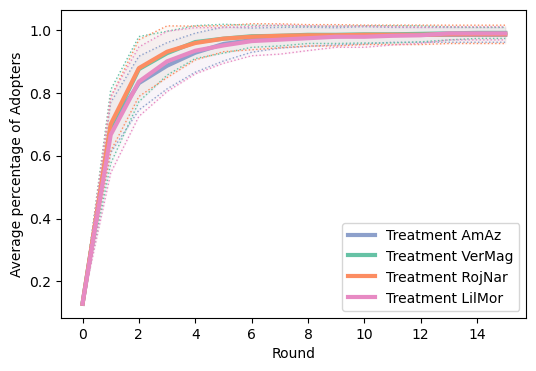

In [4]:
fig, ax = plt.subplots(figsize=(6, 4))
# Define the color palette
color = sns.color_palette("Set2",4)
color_palette = [color[2], color[0], color[1], color[3]]
perc_adopters = np.zeros((4,16,21))

for i, setup in enumerate(data[data['Setup'] != 'Instructions']['Setup'].unique()):
    setup_data = data[(data['Setup'] == setup)]
    # Add the initial round with perc_adopters equal to 4/31 (fixed value for all setups)
    setup_data = setup_data.append({'Round': 0, 'perc_adopters': 4/31}, ignore_index=True)
    mean_adopters = np.zeros(16)
    std_adopters = np.zeros(16)
    mean_adopters[0] = 4/31
    perc_adopters[i,0,:] = 4/31
    for round in range(1, 16):
        for exp in range(1, 22):
            # Calculate the percentage of adopters in each experiment
            if setup_data[(setup_data['Experiment'] == exp) & (setup_data['Round'] == round)].empty:
                perc_adopters[i,round,exp-1] = perc_adopters[i,round-1,exp-1]
            else:
                actions = setup_data[(setup_data['Experiment'] == exp) & (setup_data['Round'] == round)]['action'] == setup_data[(setup_data['Experiment'] == exp) & (setup_data['Round'] == round)]['Promoted_color']
                perc_adopters[i,round,exp-1] = np.count_nonzero(setup_data[(setup_data['Experiment'] == exp) & (setup_data['Round'] == round)]['Adopted_innovation'])/31
        # Calculate the mean and standard deviation of the percentage of adopters in each round
        mean_adopters[round] = np.mean(perc_adopters[i,round,:])
        std_adopters[round] = np.std(perc_adopters[i,round,:])
        
    # Plot the mean 'num_adopters' with shaded area representing the standard deviation
    ax.plot(range(0,16), mean_adopters, label=f"Treatment {setup}", color=color_palette[i],linewidth=3)
    ax.fill_between(range(0,16), mean_adopters - std_adopters, mean_adopters + std_adopters, alpha=0.05, color=color_palette[i], edgecolor=color_palette[i], linewidth=1)
    # Add a thicker line to delimit each shaded area
    ax.plot(range(0,16), mean_adopters - std_adopters, color=color_palette[i], linewidth=1, linestyle='dotted')
    ax.plot(range(0,16), mean_adopters + std_adopters, color=color_palette[i], linewidth=1, linestyle='dotted')

# Set the plot title and labels
ax.set_xlabel("Round")
ax.set_ylabel("Average percentage of Adopters")
ax.legend()

plt.show()

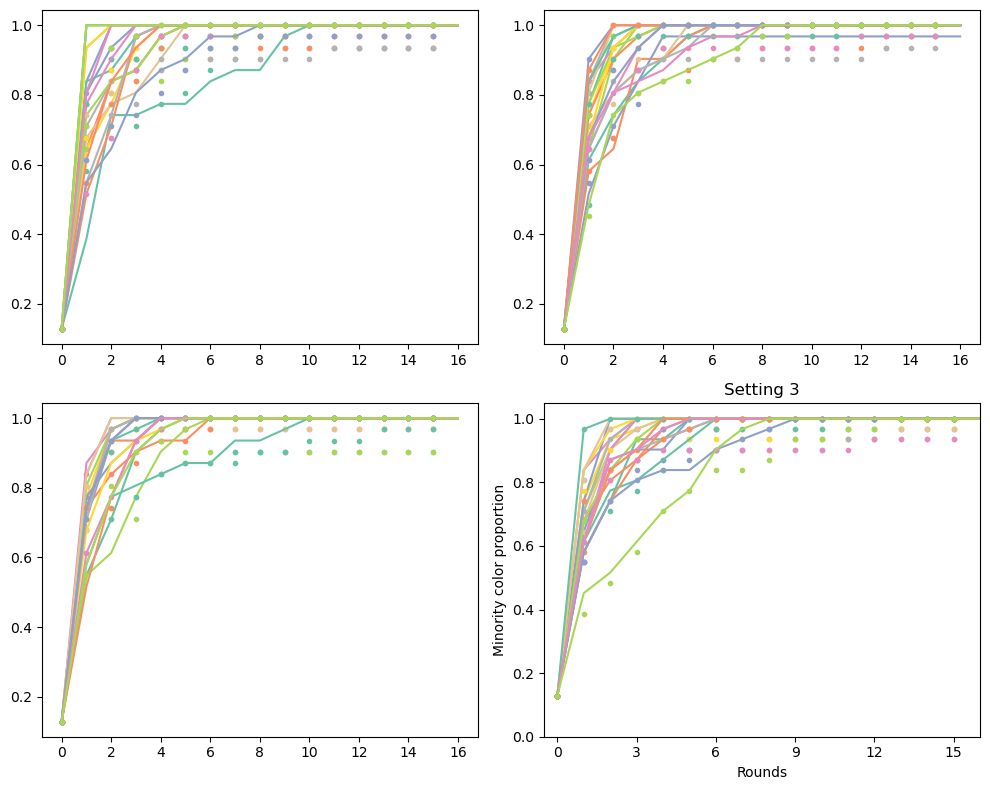

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))


# Iterate over the slices of perc_adopters
for exp in data['Experiment'].unique():
    for setupnum,setup in enumerate(data[data['Setup'] != 'Instructions']['Setup'].unique()):
        experiment_data = data[(data['Setup'] == setup) & (data['Experiment'] == exp)]
        u0 = np.array(experiment_data[experiment_data['Round'] == 1]['initialcolor'] == experiment_data[experiment_data['Round'] == 1]['Promoted_color'], dtype=int)
        if setup == 'AmAz': a=1; b=0; c=0; d=0
        if setup == 'VerMag': a=1; b=experiment_data['parameter'].unique(); c=0; d=0
        if setup == 'RojNar': a=1; b=0; c=experiment_data['parameter'].unique(); d=0
        if setup == 'LilMor': a=1; b=0; c=0; d=experiment_data['parameter'].unique()
        objective = experiment_data['threshold'].unique()
        T = int(experiment_data['Time'].unique())
        len_data = int(experiment_data['AdoptersConsensus'].unique())
        theoretical_pred = Dpath_threshold(objective, u0, a, b, c, d, T, len_data)
        while len(theoretical_pred) < 17:
            theoretical_pred = np.append(theoretical_pred, theoretical_pred[-1])
        axs[np.unravel_index(setupnum, (2,2))].plot(theoretical_pred, color=sns.color_palette("Set2",21)[exp-1])
        axs[np.unravel_index(setupnum, (2,2))].plot(perc_adopters[setupnum,:,exp-1], '.', color=sns.color_palette("Set2",21)[exp-1])
        
    # Set the title for each subplot
    axs[np.unravel_index(setupnum, (2,2))].set_title(f"Setting {setupnum}")
    axs[np.unravel_index(setupnum, (2,2))].set_xlabel('Rounds')
    axs[np.unravel_index(setupnum, (2,2))].set_ylabel('Minority color proportion')
    axs[np.unravel_index(setupnum, (2,2))].set_ylim(0,1.05)
    axs[np.unravel_index(setupnum, (2,2))].set_xlim(-0.5,16)
    axs[np.unravel_index(setupnum, (2,2))].set_xticks(range(0,16,3))    

# Adjust the spacing between subplots
plt.tight_layout()


# Show the plot
plt.show()

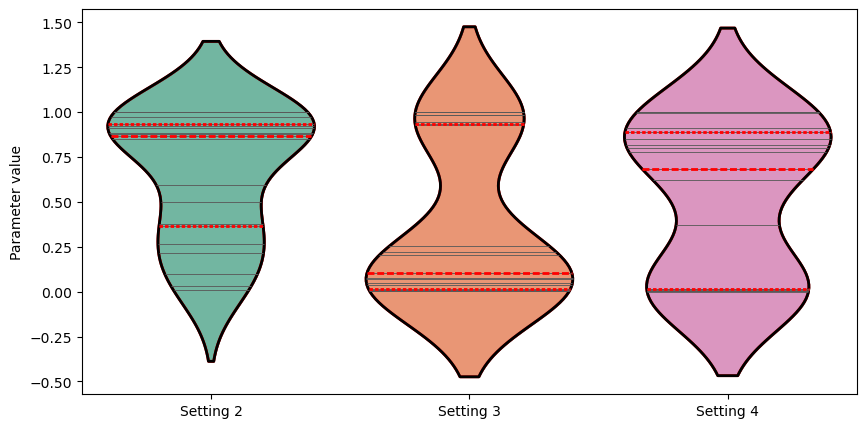

In [6]:
plt.figure(figsize=(10, 5))
parameters = np.zeros((21,3))
parameters[:,0] = data[(data['Setup'] == 'VerMag') & (data['node']==1) & (data['Round']==1)]['parameter']
parameters[:,1] = data[(data['Setup'] == 'RojNar') & (data['node']==1) & (data['Round']==1)]['parameter']
parameters[:,2] = data[(data['Setup'] == 'LilMor') & (data['node']==1) & (data['Round']==1)]['parameter']

labels = ['Setting 2', 'Setting 3', 'Setting 4']
color= sns.color_palette("Set2",4)
color_palette = [color[2], color[0], color[1], color[3]]
sns.violinplot(data=parameters, inner='stick', palette=[color_palette[1],  color_palette[2], color_palette[3]])
sns.violinplot(data=parameters, inner='quart', palette=['red','red','red'], fill=False, linewidth=2)
sns.violinplot(data=parameters, inner=None, palette=['black','black','black'], fill=False, linewidth=2)
plt.xticks(np.arange(3), labels)
plt.ylabel('Parameter value')

plt.show()

Figura María Random Forest

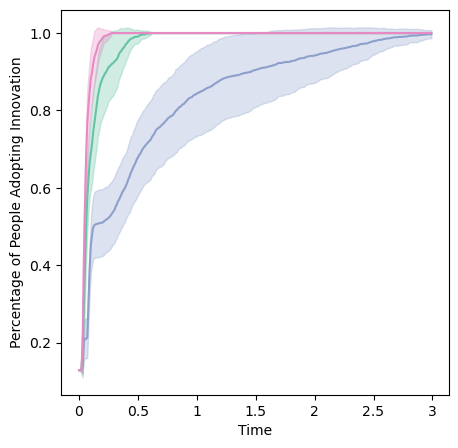

In [7]:
T=300
reps=100

classical = np.empty((reps, T))
second = np.empty((reps,T))
accelerated = np.empty((reps,T))

b = data[(data['Setup'] == 'VerMag') & (data['node']==1) & (data['Round']==1)]['parameter'].mean()
c = data[(data['Setup'] == 'RojNar') & (data['node']==1) & (data['Round']==1)]['parameter'].mean()

random.seed(9)

for rep in range(classical.shape[0]):
    starters = random.sample(range(31), 4)
    u0 = np.zeros((31,1))
    u0[starters] = 1

    classical[rep,:] = Dpath_threshold(0.5,u0,1,0,0,0,T,T)
    second[rep,:] = Dpath_threshold(0.5,u0,1,b,0,0,T,T)
    accelerated[rep,:] = Dpath_threshold(0.5,u0,1,b,c,0,T,T)

plt.figure(figsize=(5,5))

plt.plot(np.mean(classical, axis=0), color=color_palette[0], label="Close-range interactions (NN)")
plt.fill_between(range(T), np.mean(classical, axis=0)-np.std(classical, axis=0), np.mean(classical, axis=0)+np.std(classical, axis=0), color=color_palette[0], alpha=0.3)

plt.plot(np.mean(second, axis=0), color=color_palette[1], label="c_d = (4-d)/3")
plt.fill_between(range(T), np.mean(second, axis=0)-np.std(second, axis=0), np.mean(second, axis=0)+np.std(second, axis=0), color=color_palette[1], alpha=0.3)

plt.plot(np.mean(accelerated, axis=0), color=color_palette[3], label="c_d = (4-d)/2")
plt.fill_between(range(T), np.mean(accelerated, axis=0)-np.std(accelerated, axis=0), np.mean(accelerated, axis=0)+np.std(accelerated, axis=0), color=color_palette[3], alpha=0.3)

plt.xticks([0,50,100,150,200,250,300],[0,0.5,1,1.5,2,2.5,3])
plt.xlabel('Time')
plt.ylabel('Percentage of People Adopting Innovation')
plt.show()



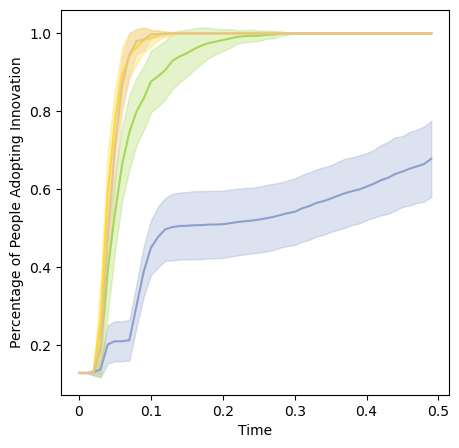

In [8]:
T=50
reps=100

classical = np.empty((reps, T))
second = np.empty((reps,T))
third = np.empty((reps,T))
accelerated = np.empty((reps,T))

random.seed(9)

for rep in range(classical.shape[0]):
    starters = random.sample(range(31), 4)
    u0 = np.zeros((31,1))
    u0[starters] = 1

    classical[rep,:] = Dpath_threshold(0.5,u0,1,0,0,0,T,T)
    second[rep,:] = Dpath_threshold(0.5,u0,1,2/3,1/3,0,T,T)
    third[rep,:] = Dpath_threshold(0.5,u0,1,3/4,1/2,1/4,T,T)
    accelerated[rep,:] = Dpath_threshold(0.5,u0,1,2/3,1/3,2/5,T,T)
    
plt.figure(figsize=(5,5))
color = sns.color_palette("Set2",7)
color_palette = [color[2], color[0], color[1], color[3], color[4], color[5], color[6]]

plt.plot(np.mean(classical, axis=0), color=color_palette[0], label="Close-range interactions (NN)")
plt.fill_between(range(T), np.mean(classical, axis=0)-np.std(classical, axis=0), np.mean(classical, axis=0)+np.std(classical, axis=0), color=color_palette[0], alpha=0.3)

plt.plot(np.mean(second, axis=0), color=color_palette[4], label="c_d = (4-d)/3")
plt.fill_between(range(T), np.mean(second, axis=0)-np.std(second, axis=0), np.mean(second, axis=0)+np.std(second, axis=0), color=color_palette[4], alpha=0.3)

plt.plot(np.mean(third, axis=0), color=color_palette[5], label="c_d = (5-d)/3")
plt.fill_between(range(T), np.mean(third, axis=0)-np.std(third, axis=0), np.mean(third, axis=0)+np.std(third, axis=0), color=color_palette[5], alpha=0.3)

plt.plot(np.mean(accelerated, axis=0), color=color_palette[6], label="c_d = (4-d)/2")
plt.fill_between(range(T), np.mean(accelerated, axis=0)-np.std(accelerated, axis=0), np.mean(accelerated, axis=0)+np.std(accelerated, axis=0), color=color_palette[6], alpha=0.3)

# plt.legend()
plt.xticks([0,10,20,30,40,50],[0,0.1,0.2,0.3,0.4,0.5])
plt.xlabel('Time')
plt.ylabel('Percentage of People Adopting Innovation')

plt.show()

In [9]:
data.columns

Index(['Experiment', 'participant.id_in_session', 'config_name', 'Setup',
       'node', 'initialcolor', 'threshold', 'parameter', 'Time',
       'AdoptersConsensus', 'SimulationConsensus', 'Round', 'preg', 'action',
       'MajorityColor', 'bot', 'color_neighbors_shown', 'color_friends_shown',
       'Adopted_innovation', 'Adopted_color', 'Promoted_color', 'num_adopters',
       'total_participants', 'perc_adopters'],
      dtype='object')

# Outlier detection

In [10]:
DataConsensus = np.zeros((4,21))
SimulationConsensus = np.zeros((4,21))

for i, setup in enumerate(data[data['Setup'] != 'Instructions']['Setup'].unique()):
    for j, exp in enumerate(data['Experiment'].unique()):
        DataConsensus[i,j] = data[(data['Setup'] == setup) & (data['Experiment'] == exp)]['AdoptersConsensus'].unique()
        SimulationConsensus[i,j] = data[(data['Setup'] == setup) & (data['Experiment'] == exp)]['SimulationConsensus'].unique()

Z-Score outliers

In [11]:
outliers_df = pd.DataFrame(columns=['Setting','Outlier','Z-score','Number of stubborn agents'])
for i in range(1,4):
    vals = np.nan_to_num(DataConsensus[i,:],nan=15)-np.nan_to_num(SimulationConsensus[i,:],nan=15)

    mean = np.nanmean(vals)
    std = np.nanstd(vals)
    
    threshold = 2
    for pos,x in enumerate(vals):
        z_score = (x - mean) / std
        if abs(z_score) > threshold:
            outliers_df = outliers_df.append({'Setting':i+1, 'Outlier':pos+1, 'Z-score':z_score, 'Number of stubborn agents':(1-perc_adopters[i,-1,pos])*31}, ignore_index=True)

outliers_df['Setting'] = outliers_df['Setting'].astype(int)
outliers_df['Outlier'] = outliers_df['Outlier'].astype(int)
outliers_df['Number of stubborn agents'] = outliers_df['Number of stubborn agents'].round().astype(int)

outliers_df

,Setting,Outlier,Z-score,Number of stubborn agents
0,2,5,2.312352,1
1,2,9,2.067103,1
2,3,7,2.139715,1


IQR outliers (Tukey's method)

In [12]:
outliers_df = pd.DataFrame(columns=['Setting', 'Outlier', 'Score', 'IQR', 'Number of stubborn agents'])
for i in range(1,4):
    vals = np.array(np.nan_to_num(DataConsensus[i,:],nan=15)-np.nan_to_num(SimulationConsensus[i,:],nan=15))
    q1 = np.nanpercentile(vals, 25)
    q3 = np.nanpercentile(vals, 75)
    iqr = q3 - q1
    k = 1.5
    lower_bound = q1 - (k * iqr)
    upper_bound = q3 + (k * iqr)
    for pos,x in enumerate(vals):
        if x < lower_bound or x > upper_bound:
            outliers_df = outliers_df.append({'Setting': i+1,'Outlier': pos+1,'Score': x,'IQR': iqr,'Number of stubborn agents': (1-perc_adopters[i,-1,pos])*31}, ignore_index=True)

outliers_df['Setting'] = outliers_df['Setting'].astype(int)
outliers_df['Outlier'] = outliers_df['Outlier'].astype(int)
outliers_df['Score'] = outliers_df['Score'].astype(int)
outliers_df['IQR'] = outliers_df['IQR'].astype(int)
outliers_df['Number of stubborn agents'] = outliers_df['Number of stubborn agents'].round().astype(int)

outliers_df

,Setting,Outlier,Score,IQR,Number of stubborn agents
0,2,2,10,2,1
1,2,5,13,2,1
2,2,9,12,2,1
3,2,16,10,2,2
4,2,20,8,2,1
5,3,1,10,3,3
6,3,2,10,3,1
7,3,5,10,3,3
8,3,7,11,3,1


Mean Regression

In [13]:
outliers_df = pd.DataFrame(columns=['Setting','Outlier','Score','Number of stubborn agents'])
for i in range(1,4):
    vals = np.array(np.nan_to_num(DataConsensus[i,:],nan=15)-np.nan_to_num(SimulationConsensus[i,:],nan=15))

    score =np.zeros(len(vals))
    mean = np.nanmean(vals)
    for j in range(len(vals)):
        score[j] = mean - np.nanmean(np.delete(vals, j))
    
    for pos,x in enumerate(score):
        if x > np.mean(score) + 1/2*np.std(score):
            outliers_df = outliers_df.append({'Setting': i+1, 'Outlier': pos+1, 'Score': x, 'Number of stubborn agents': (1-perc_adopters[i,-1,pos])*31}, ignore_index=True)

outliers_df['Setting'] = outliers_df['Setting'].astype("Int64")
outliers_df['Outlier'] = outliers_df['Outlier'].astype("Int64")
outliers_df['Number of stubborn agents'] = outliers_df['Number of stubborn agents'].round().astype("Int64")

outliers_df

,Setting,Outlier,Score,Number of stubborn agents
0,2,2,0.321429,1
1,2,5,0.471429,1
2,2,9,0.421429,1
3,2,16,0.321429,2
4,2,20,0.221429,1
5,3,1,0.316667,3
6,3,2,0.316667,1
7,3,5,0.316667,3
8,3,7,0.366667,1
9,3,9,0.116667,1


# SI Figures

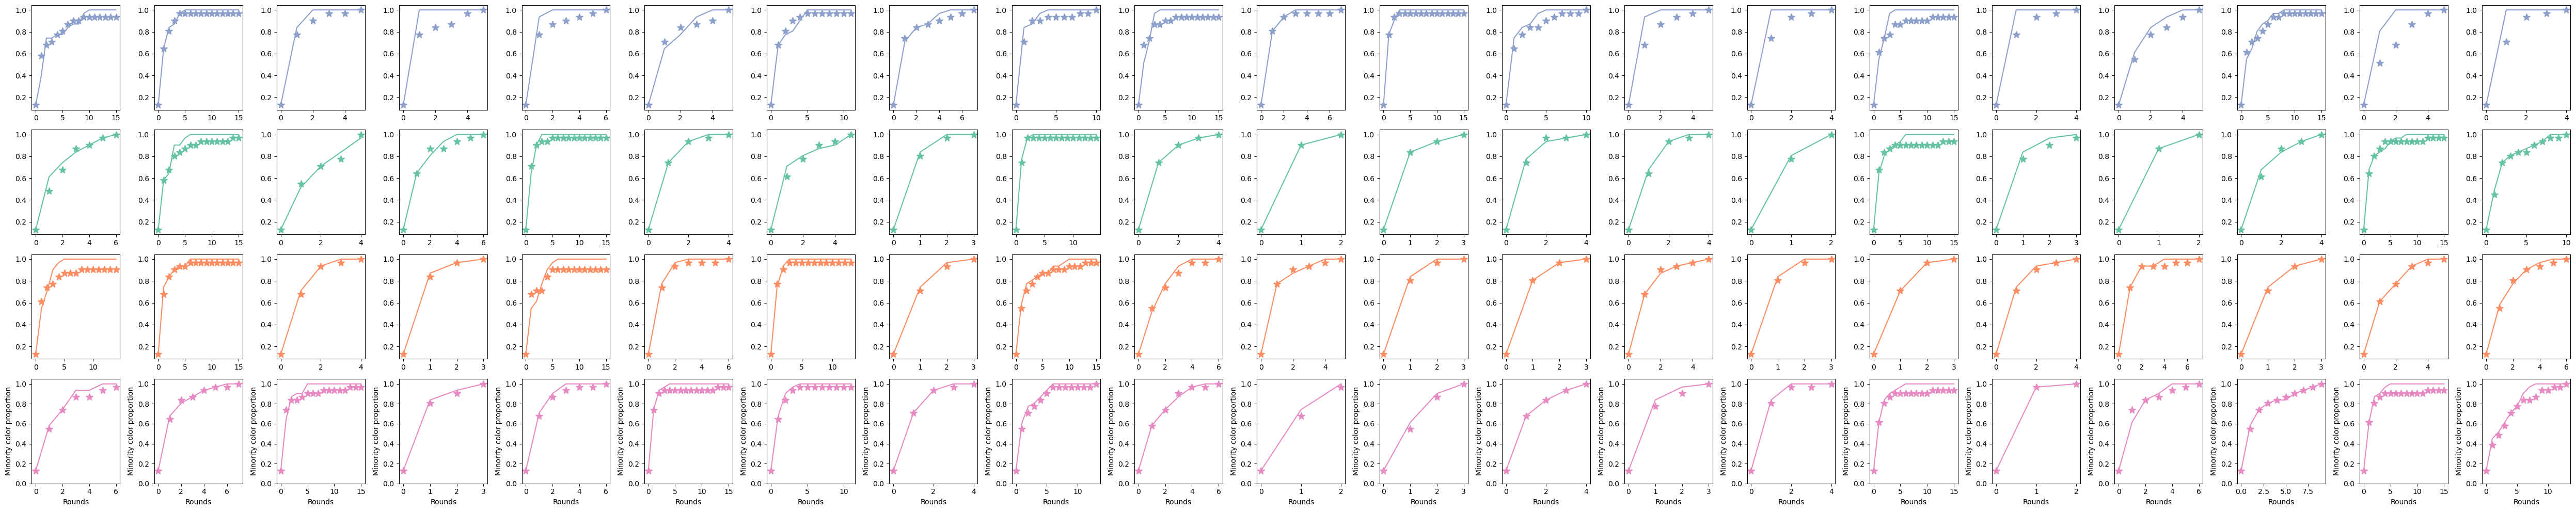

In [24]:
fig, axs = plt.subplots(4, 21, figsize=(50, 10))

color = sns.color_palette("Set2",4)
color_palette = [color[2], color[0], color[1], color[3]]

for expnum,exp in enumerate(data['Experiment'].unique()):
    for setupnum,setup in enumerate(data[data['Setup'] != 'Instructions']['Setup'].unique()):
        experiment_data = data[(data['Setup'] == setup) & (data['Experiment'] == exp)]
        u0 = np.array(experiment_data[experiment_data['Round'] == 1]['initialcolor'] == experiment_data[experiment_data['Round'] == 1]['Promoted_color'], dtype=int)
        if setup == 'AmAz': a=1; b=0; c=0; d=0
        if setup == 'VerMag': a=1; b=experiment_data['parameter'].unique(); c=0; d=0
        if setup == 'RojNar': a=1; b=0; c=experiment_data['parameter'].unique(); d=0
        if setup == 'LilMor': a=1; b=0; c=0; d=experiment_data['parameter'].unique()
        objective = experiment_data['threshold'].unique()
        T = int(experiment_data['Time'].unique())
        len_data = int(experiment_data['AdoptersConsensus'].unique())
        theoretical_pred = Dpath_threshold(objective, u0, a, b, c, d, T, len_data)
        axs[setupnum,expnum].plot(theoretical_pred, color=color_palette[setupnum])
        axs[setupnum,expnum].plot(perc_adopters[setupnum,:len_data,exp-1], '*', color=color_palette[setupnum], markersize=10)
        
    # Set the title for each subplot
    axs[setupnum,expnum].set_xlabel('Rounds')
    axs[setupnum,expnum].set_ylabel('Minority color proportion')
    axs[setupnum,expnum].set_ylim(0,1.05)

# Adjust the spacing between subplots
plt.tight_layout()


# Show the plot
plt.show()

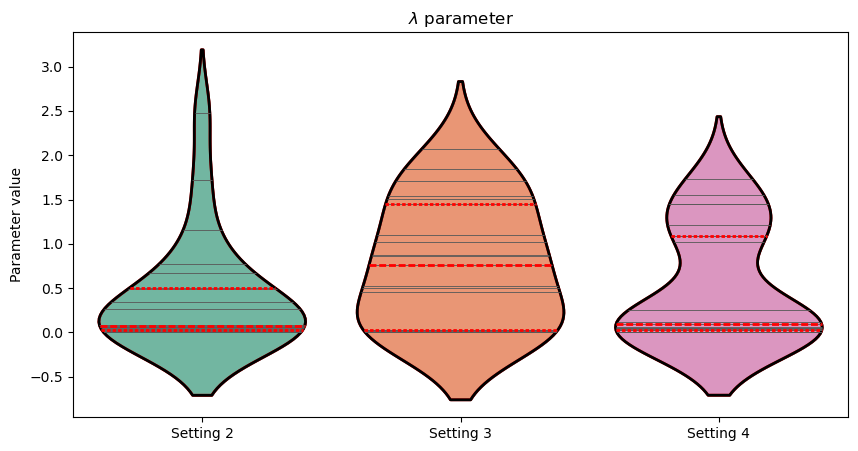

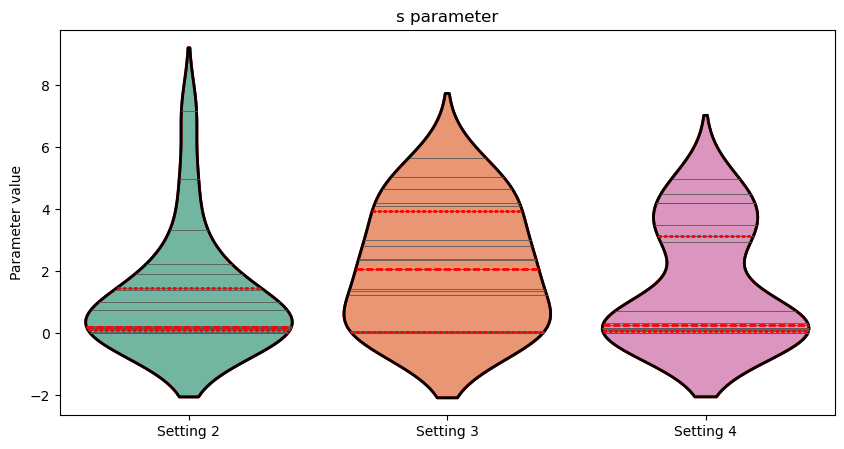

In [14]:
parameters = np.zeros((21,3))
lambda_params = np.zeros((21,3))
s_params = np.zeros((21,3))

parameters[:,0] = data[(data['Setup'] == 'VerMag') & (data['node']==1) & (data['Round']==1)]['parameter']
parameters[:,1] = data[(data['Setup'] == 'RojNar') & (data['node']==1) & (data['Round']==1)]['parameter']
parameters[:,2] = data[(data['Setup'] == 'LilMor') & (data['node']==1) & (data['Round']==1)]['parameter']

lambda_params[:,0] = -np.log(parameters[:,0])/(2)
lambda_params[:,1] = -np.log(parameters[:,1])/(3)
lambda_params[:,2] = -np.log(parameters[:,2])/(4)

s_params[:,0] = -np.log(parameters[:,0])/np.log(2)
s_params[:,1] = -np.log(parameters[:,1])/np.log(3)
s_params[:,2] = -np.log(parameters[:,2])/np.log(4)

labels = ['Setting 2', 'Setting 3', 'Setting 4']
color= sns.color_palette("Set2",4)
color_palette = [color[2], color[0], color[1], color[3]]

plt.figure(figsize=(10, 5))
sns.violinplot(data=lambda_params, inner='stick', palette=[color_palette[1],  color_palette[2], color_palette[3]])
sns.violinplot(data=lambda_params, inner='quart', palette=['red','red','red'], fill=False, linewidth=2)
sns.violinplot(data=lambda_params, inner=None, palette=['black','black','black'], fill=False, linewidth=2)
plt.xticks(np.arange(3), labels)
plt.ylabel('Parameter value')
plt.title(r'$\lambda$ parameter')

plt.show()

plt.figure(figsize=(10, 5))
sns.violinplot(data=s_params, inner='stick', palette=[color_palette[1],  color_palette[2], color_palette[3]])
sns.violinplot(data=s_params, inner='quart', palette=['red','red','red'], fill=False, linewidth=2)
sns.violinplot(data=s_params, inner=None, palette=['black','black','black'], fill=False, linewidth=2)
plt.xticks(np.arange(3), labels)
plt.ylabel('Parameter value')
plt.title('s parameter')

plt.show()

0.6451699912142079 1.627285426474511 [0.2094533656289497, 2.0769674514842493, 0.2742995497511639]


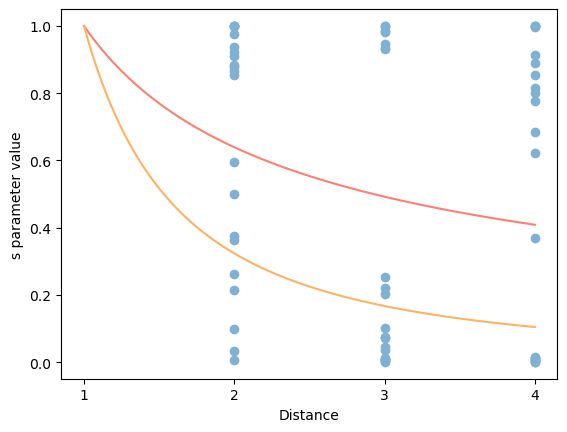

In [15]:
def power_law(x, b):
    return x ** (-b)

x = np.concatenate((2*np.ones(len(parameters[:,0])), 3*np.ones(len(parameters[:,1])), 4*np.ones(len(parameters[:,2]))))
y = np.concatenate((parameters[:,0], parameters[:,1], parameters[:,2]))

params = sp.optimize.curve_fit(power_law, x, y)

plt.plot(x, y, 'o', color = sns.color_palette("Set3")[4])
plt.plot(np.linspace(1,4,100), power_law(np.linspace(1,4,100), params[0][0]), color = sns.color_palette("Set3")[3])
plt.plot(np.linspace(1,4,100), power_law(np.linspace(1,4,100), np.mean(s_params)), color = sns.color_palette("Set3")[5])
plt.xlabel('Distance')
plt.ylabel('s parameter value')
plt.xticks([1,2,3,4])


print(params[0][0], np.mean(s_params), [np.median(s_params[:,0]), np.median(s_params[:,1]), np.median(s_params[:,2])])

0.6451699912142079 0.5778397466337792 [0.07259100492224892, 0.7605939884547608, 0.09506497976944085]


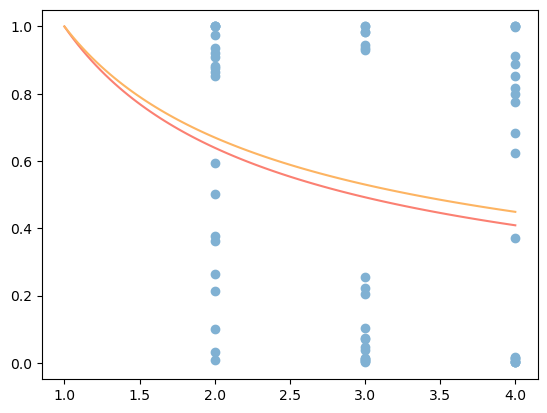

In [16]:
def exponential(x, b):
    return np.exp((-b) * x)

x = np.concatenate((2*np.ones(len(parameters[:,0])), 3*np.ones(len(parameters[:,1])), 4*np.ones(len(parameters[:,2]))))
y = np.concatenate((parameters[:,0], parameters[:,1], parameters[:,2]))

params = sp.optimize.curve_fit(power_law, x, y)

plt.plot(x, y, 'o', color = sns.color_palette("Set3")[4])
plt.plot(np.linspace(1,4,100), power_law(np.linspace(1,4,100), params[0][0]), color = sns.color_palette("Set3")[3])
plt.plot(np.linspace(1,4,100), power_law(np.linspace(1,4,100), np.mean(lambda_params)), color = sns.color_palette("Set3")[5])

print(params[0][0], np.mean(lambda_params), [np.median(lambda_params[:,0]), np.median(lambda_params[:,1]), np.median(lambda_params[:,2])])

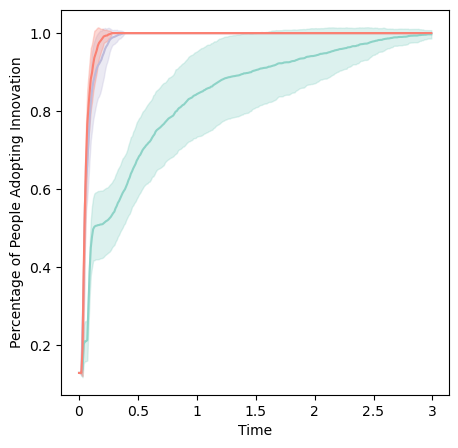

In [17]:
T=300
reps=100
color_palette = sns.color_palette("Set3",4)

classical = np.empty((reps, T))
medi = np.empty((reps,T))
accelerated = np.empty((reps,T))

b = data[(data['Setup'] == 'VerMag') & (data['node']==1) & (data['Round']==1)]['parameter'].mean()
c = data[(data['Setup'] == 'RojNar') & (data['node']==1) & (data['Round']==1)]['parameter'].mean()

med_b = np.median(data[(data['Setup'] == 'VerMag') & (data['node']==1) & (data['Round']==1)]['parameter'])
med_c = np.median(data[(data['Setup'] == 'RojNar') & (data['node']==1) & (data['Round']==1)]['parameter'])

random.seed(9)

for rep in range(classical.shape[0]):
    starters = random.sample(range(31), 4)
    u0 = np.zeros((31,1))
    u0[starters] = 1

    classical[rep,:] = Dpath_threshold(0.5,u0,1,0,0,0,T,T)
    medi[rep,:] = Dpath_threshold(0.5,u0,1,med_b,med_c,0,T,T)
    accelerated[rep,:] = Dpath_threshold(0.5,u0,1,b,c,0,T,T)

plt.figure(figsize=(5,5))

plt.plot(np.mean(classical, axis=0), color=color_palette[0], label="Close-range interactions (NN)")
plt.fill_between(range(T), np.mean(classical, axis=0)-np.std(classical, axis=0), np.mean(classical, axis=0)+np.std(classical, axis=0), color=color_palette[0], alpha=0.3)

plt.plot(np.mean(medi, axis=0), color=color_palette[2], label="c_d = (4-d)/3")
plt.fill_between(range(T), np.mean(medi, axis=0)-np.std(medi, axis=0), np.mean(medi, axis=0)+np.std(medi, axis=0), color=color_palette[2], alpha=0.3)

plt.plot(np.mean(accelerated, axis=0), color=color_palette[3], label="c_d = (4-d)/2")
plt.fill_between(range(T), np.mean(accelerated, axis=0)-np.std(accelerated, axis=0), np.mean(accelerated, axis=0)+np.std(accelerated, axis=0), color=color_palette[3], alpha=0.3)

plt.xticks([0,50,100,150,200,250,300],[0,0.5,1,1.5,2,2.5,3])
plt.xlabel('Time')
plt.ylabel('Percentage of People Adopting Innovation')
plt.show()